In [ ]:
%matplotlib inline


Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.



 ship  frog   dog truck


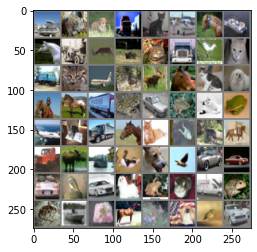

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Using GPU to Training

In [ ]:
torch.cuda.set_device(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", torch.cuda.current_device(), torch.cuda.get_device_name(torch.cuda.current_device()))

device 0 Tesla T4


2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [ ]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net_deeper(nn.Module):
    def __init__(self):
        super(Net_deeper, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 3, 1, 1)    # new conv by 3x3 kernel
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)   # new conv by 3x3 kernel
        self.conv4 = nn.Conv2d(32, 16, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # in_shape = (batch, 3, 32, 32)
        x = self.pool(F.relu(self.conv1(x)))

        '''
        c1 32 + 0 - 4 - 1 + 1 = 28
        p1 (28 + 0 - 1 - 1) / 2 + 1 = 14

        c2 14 + 2 - 2 - 1 + 1 = 14
        p2 (14 + 0 -1 -1) / 2 + 1 = 7

        c3 7 + 2 - 2 - 1 + 1 = 7
        p3 (7 + 0 -1 -1) / 2 + 1 = 3 

        c4 3 + 0 - 4 - 1 + 1 = ?
        p4 (10 + 0 -1 -1 ) / 2 + 1 = 5
        '''

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Net_wider(nn.Module):
    def __init__(self):
        super(Net_wider, self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 5)
        self.conv2 = nn.Conv2d(12, 32, 5)
        self.fc1 = nn.Linear(32 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


#net = Net().to(device)
#net_deeper = Net_deeper().to(device)
#net_wider = Net_wider().to(device)

def get_net(net_name):
    if net_name == "Net":
        return Net()
    elif net_name == "Net_deeper":
        return Net_deeper()
    elif net_name == "Net_wider":
        return Net_wider()
    else:
        return None

3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

def get_optimizer(opt_name, net_parameter, lr=0.001, momentum=0.9):
    if opt_name == "SGD":
        opt = optim.SGD(net_parameter, lr=lr, momentum=momentum)
    elif opt_name == "Adam":
        opt = optim.Adam(net_parameter, lr=lr)
    elif opt_name == "RMSprop":
        opt = optim.RMSprop(net_parameter, lr=lr, momentum=momentum)
    else:
        return None
    return opt

4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
def train(net_name, opt_name, lr=0.001, eps=10):

    net = get_net(net_name).to(device)
    optimizer = get_optimizer(opt_name, net.parameters(), lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(eps):  # loop over the dataset multiple times

        running_loss = 0.0  #?????????
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            if i == 0:
                print(f"\nEpoch:{epoch+1}")
                print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

    print('\nFinished Training')
    return net

#net = train("Net", "SGD")

5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



GroundTruth:    cat  ship  ship plane


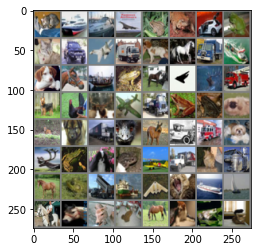

In [ ]:
# ############################ unnecessary ##############################
# dataiter = iter(testloader)
# images, labels = dataiter.next()

# # print images
# imshow(torchvision.utils.make_grid(images))
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Okay, now let us see what the neural network thinks these examples above are:



In [ ]:
# ############################ unnecessary ##############################
# net.eval()
# with torch.no_grad():
#   outputs = net(images.to(device))

The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



In [ ]:
# ############################ unnecessary ##############################
# _, predicted = torch.max(outputs, 1)

# print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
#                               for j in range(4)))

Predicted:    cat  ship   car  ship


The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [ ]:
# ############################ unnecessary ##############################
# correct = 0
# total = 0
# net.eval()
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images.to(device))
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted.cpu() == labels).sum().item()

# print('Accuracy of the network on the 10000 test images: %d %%' % (
#     100 * correct / total))

Accuracy of the network on the 10000 test images: 52 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [ ]:
# ############################ unnecessary ##############################
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
# preds = np.zeros((1))
# truth = np.zeros((1))
# net.eval()
# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images.to(device))
#         _, predicted = torch.max(outputs, 1)
#         c = (predicted.cpu() == labels).squeeze()
#         preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
#         truth = np.concatenate([truth, labels.numpy()], axis=0)
#         for i in range(4):
#             label = labels[i]
#             class_correct[label] += c[i].item()
#             class_total[label] += 1


# for i in range(10):
#     print('Accuracy of %5s : %2d %%' % (
#         classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 51 %
Accuracy of   car : 74 %
Accuracy of  bird : 35 %
Accuracy of   cat : 21 %
Accuracy of  deer : 32 %
Accuracy of   dog : 47 %
Accuracy of  frog : 64 %
Accuracy of horse : 64 %
Accuracy of  ship : 55 %
Accuracy of truck : 60 %


Display the confusion matrix as a heatmap

Text(60.0, 0.5, 'label (ground truth)')

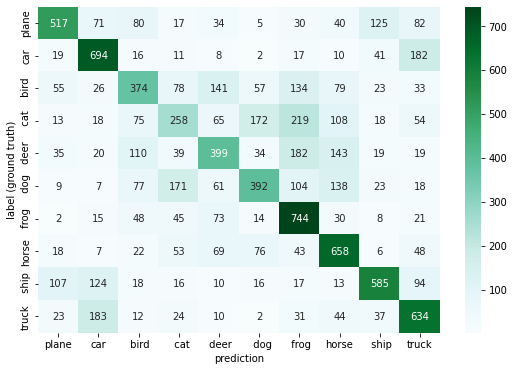

In [ ]:
# ############################ unnecessary ##############################
# import pandas as pd
# import seaborn as sns
# from sklearn.metrics import confusion_matrix
# # Display the confusion matrix as a heatmap
# arr = confusion_matrix(truth, preds)
# class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
# df_cm = pd.DataFrame(arr, class_names, class_names)
# plt.figure(figsize = (9,6))
# sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
# plt.xlabel("prediction")
# plt.ylabel("label (ground truth)")

Some multi-class performance report defined from Scikit-learn

In [ ]:
# ############################ unnecessary ##############################
# from sklearn.metrics import classification_report
# print(classification_report(truth, preds, target_names=class_names))

              precision    recall  f1-score   support

       plane       0.65      0.52      0.57      1001
         car       0.60      0.69      0.64      1000
        bird       0.45      0.37      0.41      1000
         cat       0.36      0.26      0.30      1000
        deer       0.46      0.40      0.43      1000
         dog       0.51      0.39      0.44      1000
        frog       0.49      0.74      0.59      1000
       horse       0.52      0.66      0.58      1000
        ship       0.66      0.58      0.62      1000
       truck       0.54      0.63      0.58      1000

    accuracy                           0.53     10001
   macro avg       0.52      0.53      0.52     10001
weighted avg       0.52      0.53      0.52     10001



In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


def test(net):
    print("\nStart to testing!\n")
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted.cpu() == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    ###########################
    print("\nAccuracy of each class:")
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    preds = np.zeros((1))
    truth = np.zeros((1))
    net.eval()
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images.to(device))
            _, predicted = torch.max(outputs, 1)
            c = (predicted.cpu() == labels).squeeze()
            preds = np.concatenate([preds, predicted.cpu().numpy()], axis=0)
            truth = np.concatenate([truth, labels.numpy()], axis=0)
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))
    ##########################
    print("\nclassification_report:")
    class_names = ['plane', 'car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']
    print(classification_report(truth, preds, target_names=class_names))    
    ###########################
    print("Confusion matrix:")
    # Display the confusion matrix as a heatmap
    arr = confusion_matrix(truth, preds)
    df_cm = pd.DataFrame(arr, class_names, class_names)
    plt.figure(figsize = (9,6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
    plt.xlabel("prediction")
    plt.ylabel("label (ground truth)")
    ###########################



<h3>training in default setting<h3>


Epoch:1
	Batch:001 of 782, loss:2.288
Epoch:2
	Batch:001 of 782, loss:2.292
Epoch:3
	Batch:001 of 782, loss:1.900
Epoch:4
	Batch:001 of 782, loss:1.696
Epoch:5
	Batch:001 of 782, loss:1.522
Epoch:6
	Batch:001 of 782, loss:1.626
Epoch:7
	Batch:001 of 782, loss:1.356
Epoch:8
	Batch:001 of 782, loss:1.621
Epoch:9
	Batch:001 of 782, loss:1.427
Epoch:10
	Batch:001 of 782, loss:1.226
Finished Training

Start to testing!

Accuracy of the network on the 10000 test images: 51 %

Accuracy of each class:
Accuracy of plane : 51 %
Accuracy of   car : 76 %
Accuracy of  bird : 24 %
Accuracy of   cat : 31 %
Accuracy of  deer : 25 %
Accuracy of   dog : 44 %
Accuracy of  frog : 71 %
Accuracy of horse : 53 %
Accuracy of  ship : 65 %
Accuracy of truck : 53 %

classification_report:
              precision    recall  f1-score   support

       plane       0.67      0.46      0.55      1001
         car       0.59      0.73      0.65      1000
        bird       0.43      0.30      0.36      1000
         

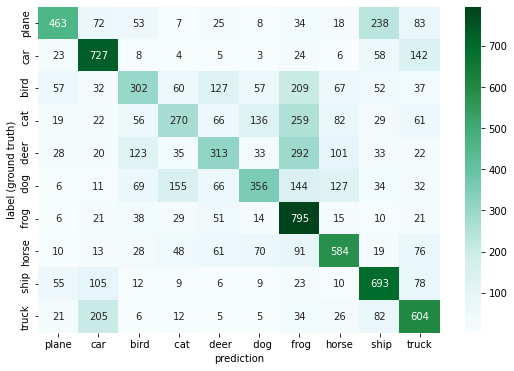

In [ ]:
net = train("Net", "SGD")
test(net)

<h3>training with insert two 3x3 conv layers<h3>


Epoch:1
	Batch:001 of 782, loss:2.322
Epoch:2
	Batch:001 of 782, loss:2.299
Epoch:3
	Batch:001 of 782, loss:2.301
Epoch:4
	Batch:001 of 782, loss:2.297
Epoch:5
	Batch:001 of 782, loss:2.131
Epoch:6
	Batch:001 of 782, loss:2.268
Epoch:7
	Batch:001 of 782, loss:1.726
Epoch:8
	Batch:001 of 782, loss:1.673
Epoch:9
	Batch:001 of 782, loss:1.514
Epoch:10
	Batch:001 of 782, loss:1.608
Finished Training

Start to testing!

Accuracy of the network on the 10000 test images: 45 %

Accuracy of each class:
Accuracy of plane : 62 %
Accuracy of   car : 54 %
Accuracy of  bird : 26 %
Accuracy of   cat : 20 %
Accuracy of  deer : 12 %
Accuracy of   dog : 25 %
Accuracy of  frog : 67 %
Accuracy of horse : 54 %
Accuracy of  ship : 68 %
Accuracy of truck : 64 %

classification_report:
              precision    recall  f1-score   support

       plane       0.49      0.48      0.49      1001
         car       0.55      0.65      0.60      1000
        bird       0.40      0.26      0.31      1000
         

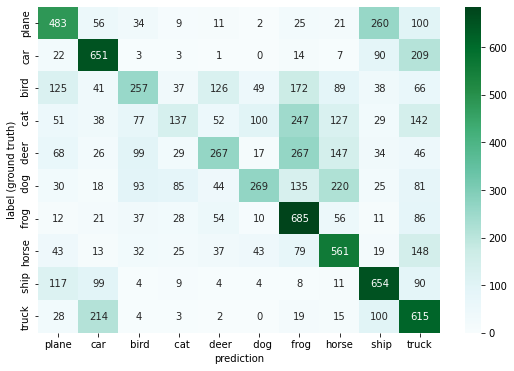

In [ ]:
net = train("Net_deeper", "SGD")
test(net)

<h3>training with more neuron<h3>


Epoch:1
	Batch:001 of 782, loss:2.312
Epoch:2
	Batch:001 of 782, loss:2.218
Epoch:3
	Batch:001 of 782, loss:1.848
Epoch:4
	Batch:001 of 782, loss:1.919
Epoch:5
	Batch:001 of 782, loss:1.650
Epoch:6
	Batch:001 of 782, loss:1.493
Epoch:7
	Batch:001 of 782, loss:1.260
Epoch:8
	Batch:001 of 782, loss:1.284
Epoch:9
	Batch:001 of 782, loss:1.301
Epoch:10
	Batch:001 of 782, loss:1.243
Finished Training

Start to testing!

Accuracy of the network on the 10000 test images: 56 %

Accuracy of each class:
Accuracy of plane : 58 %
Accuracy of   car : 74 %
Accuracy of  bird : 22 %
Accuracy of   cat : 21 %
Accuracy of  deer : 36 %
Accuracy of   dog : 62 %
Accuracy of  frog : 57 %
Accuracy of horse : 67 %
Accuracy of  ship : 70 %
Accuracy of truck : 60 %

classification_report:
              precision    recall  f1-score   support

       plane       0.61      0.61      0.61      1001
         car       0.69      0.69      0.69      1000
        bird       0.54      0.33      0.41      1000
         

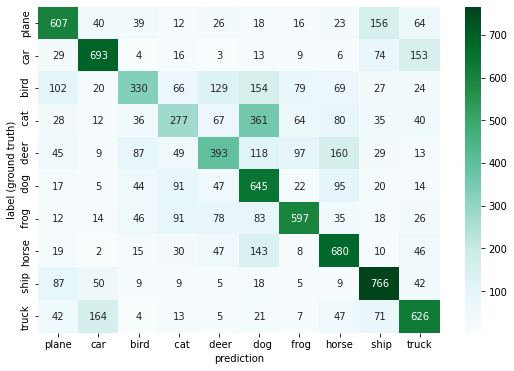

In [ ]:
net = train("Net_wider", "SGD")
test(net)


Epoch:1
	Batch:001 of 782, loss:2.310
Epoch:2
	Batch:001 of 782, loss:2.287
Epoch:3
	Batch:001 of 782, loss:1.960
Epoch:4
	Batch:001 of 782, loss:1.782
Epoch:5
	Batch:001 of 782, loss:1.639
Epoch:6
	Batch:001 of 782, loss:1.447
Epoch:7
	Batch:001 of 782, loss:1.814
Epoch:8
	Batch:001 of 782, loss:1.516
Epoch:9
	Batch:001 of 782, loss:1.582
Epoch:10
	Batch:001 of 782, loss:1.344
Epoch:11
	Batch:001 of 782, loss:1.360
Epoch:12
	Batch:001 of 782, loss:1.288
Epoch:13
	Batch:001 of 782, loss:1.410
Epoch:14
	Batch:001 of 782, loss:1.151
Epoch:15
	Batch:001 of 782, loss:1.466
Epoch:16
	Batch:001 of 782, loss:1.117
Epoch:17
	Batch:001 of 782, loss:1.343
Epoch:18
	Batch:001 of 782, loss:0.971
Epoch:19
	Batch:001 of 782, loss:1.212
Epoch:20
	Batch:001 of 782, loss:1.115
Epoch:21
	Batch:001 of 782, loss:1.242
Epoch:22
	Batch:001 of 782, loss:1.091
Epoch:23
	Batch:001 of 782, loss:0.832
Epoch:24
	Batch:001 of 782, loss:1.159
Epoch:25
	Batch:001 of 782, loss:0.805
Epoch:26
	Batch:001 of 782, loss:

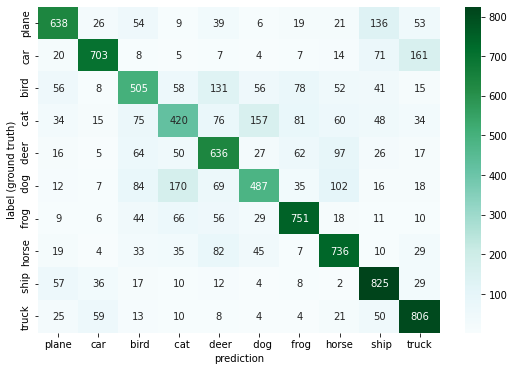

In [ ]:
net = train("Net", "SGD", eps=50)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.291
Epoch:2
	Batch:001 of 782, loss:2.307
Epoch:3
	Batch:001 of 782, loss:2.302
Epoch:4
	Batch:001 of 782, loss:2.303
Epoch:5
	Batch:001 of 782, loss:2.301
Epoch:6
	Batch:001 of 782, loss:2.268
Epoch:7
	Batch:001 of 782, loss:1.952
Epoch:8
	Batch:001 of 782, loss:1.731
Epoch:9
	Batch:001 of 782, loss:1.665
Epoch:10
	Batch:001 of 782, loss:1.552
Epoch:11
	Batch:001 of 782, loss:1.332
Epoch:12
	Batch:001 of 782, loss:1.498
Epoch:13
	Batch:001 of 782, loss:1.380
Epoch:14
	Batch:001 of 782, loss:1.491
Epoch:15
	Batch:001 of 782, loss:1.222
Epoch:16
	Batch:001 of 782, loss:1.455
Epoch:17
	Batch:001 of 782, loss:1.348
Epoch:18
	Batch:001 of 782, loss:1.188
Epoch:19
	Batch:001 of 782, loss:1.188
Epoch:20
	Batch:001 of 782, loss:1.065
Epoch:21
	Batch:001 of 782, loss:1.090
Epoch:22
	Batch:001 of 782, loss:1.316
Epoch:23
	Batch:001 of 782, loss:1.332
Epoch:24
	Batch:001 of 782, loss:0.885
Epoch:25
	Batch:001 of 782, loss:1.225
Epoch:26
	Batch:001 of 782, loss:

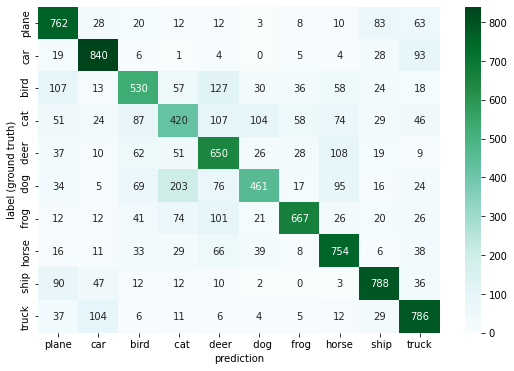

In [ ]:
net = train("Net_deeper", "SGD", eps=50)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.327
Epoch:2
	Batch:001 of 782, loss:2.214
Epoch:3
	Batch:001 of 782, loss:1.769
Epoch:4
	Batch:001 of 782, loss:1.647
Epoch:5
	Batch:001 of 782, loss:1.624
Epoch:6
	Batch:001 of 782, loss:1.688
Epoch:7
	Batch:001 of 782, loss:1.524
Epoch:8
	Batch:001 of 782, loss:1.496
Epoch:9
	Batch:001 of 782, loss:1.242
Epoch:10
	Batch:001 of 782, loss:1.114
Epoch:11
	Batch:001 of 782, loss:1.223
Epoch:12
	Batch:001 of 782, loss:1.233
Epoch:13
	Batch:001 of 782, loss:1.207
Epoch:14
	Batch:001 of 782, loss:0.945
Epoch:15
	Batch:001 of 782, loss:0.983
Epoch:16
	Batch:001 of 782, loss:1.068
Epoch:17
	Batch:001 of 782, loss:0.862
Epoch:18
	Batch:001 of 782, loss:0.918
Epoch:19
	Batch:001 of 782, loss:0.902
Epoch:20
	Batch:001 of 782, loss:0.885
Epoch:21
	Batch:001 of 782, loss:0.780
Epoch:22
	Batch:001 of 782, loss:0.895
Epoch:23
	Batch:001 of 782, loss:0.752
Epoch:24
	Batch:001 of 782, loss:0.881
Epoch:25
	Batch:001 of 782, loss:0.864
Epoch:26
	Batch:001 of 782, loss:

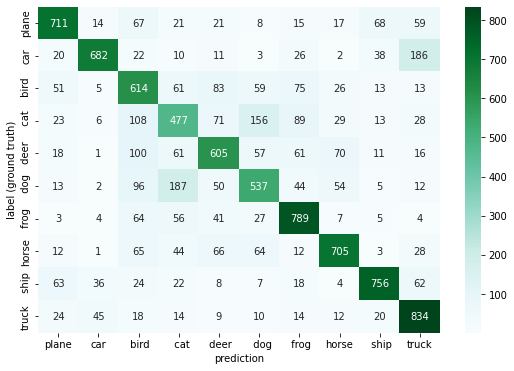

In [ ]:
net = train("Net_wider", "SGD", eps=50)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.294
Epoch:2
	Batch:001 of 782, loss:1.080
Epoch:3
	Batch:001 of 782, loss:1.525
Epoch:4
	Batch:001 of 782, loss:1.191
Epoch:5
	Batch:001 of 782, loss:1.126
Epoch:6
	Batch:001 of 782, loss:1.127
Epoch:7
	Batch:001 of 782, loss:1.121
Epoch:8
	Batch:001 of 782, loss:1.034
Epoch:9
	Batch:001 of 782, loss:0.671
Epoch:10
	Batch:001 of 782, loss:0.903
Epoch:11
	Batch:001 of 782, loss:0.778
Epoch:12
	Batch:001 of 782, loss:1.218
Epoch:13
	Batch:001 of 782, loss:0.748
Epoch:14
	Batch:001 of 782, loss:0.754
Epoch:15
	Batch:001 of 782, loss:0.795
Epoch:16
	Batch:001 of 782, loss:1.001
Epoch:17
	Batch:001 of 782, loss:0.792
Epoch:18
	Batch:001 of 782, loss:0.658
Epoch:19
	Batch:001 of 782, loss:0.870
Epoch:20
	Batch:001 of 782, loss:0.909
Epoch:21
	Batch:001 of 782, loss:0.864
Epoch:22
	Batch:001 of 782, loss:0.549
Epoch:23
	Batch:001 of 782, loss:0.636
Epoch:24
	Batch:001 of 782, loss:0.684
Epoch:25
	Batch:001 of 782, loss:0.694
Epoch:26
	Batch:001 of 782, loss:

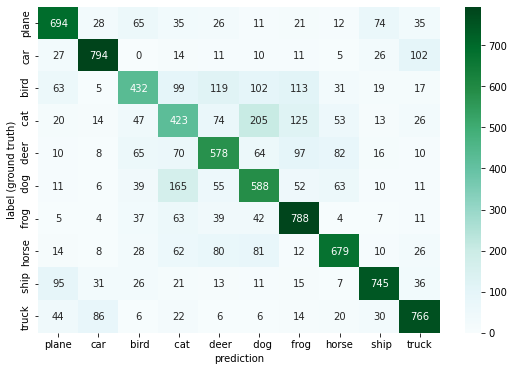

In [ ]:
net = train("Net_deeper", "Adam", eps=50)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.308
Epoch:2
	Batch:001 of 782, loss:1.759
Epoch:3
	Batch:001 of 782, loss:1.823
Epoch:4
	Batch:001 of 782, loss:1.596
Epoch:5
	Batch:001 of 782, loss:1.596
Epoch:6
	Batch:001 of 782, loss:1.449
Epoch:7
	Batch:001 of 782, loss:1.541
Epoch:8
	Batch:001 of 782, loss:1.495
Epoch:9
	Batch:001 of 782, loss:1.482
Epoch:10
	Batch:001 of 782, loss:1.447
Epoch:11
	Batch:001 of 782, loss:1.461
Epoch:12
	Batch:001 of 782, loss:1.497
Epoch:13
	Batch:001 of 782, loss:1.649
Epoch:14
	Batch:001 of 782, loss:1.602
Epoch:15
	Batch:001 of 782, loss:1.254
Epoch:16
	Batch:001 of 782, loss:1.602
Epoch:17
	Batch:001 of 782, loss:1.283
Epoch:18
	Batch:001 of 782, loss:1.510
Epoch:19
	Batch:001 of 782, loss:1.237
Epoch:20
	Batch:001 of 782, loss:1.637
Epoch:21
	Batch:001 of 782, loss:1.535
Epoch:22
	Batch:001 of 782, loss:1.551
Epoch:23
	Batch:001 of 782, loss:1.368
Epoch:24
	Batch:001 of 782, loss:1.293
Epoch:25
	Batch:001 of 782, loss:1.177
Epoch:26
	Batch:001 of 782, loss:

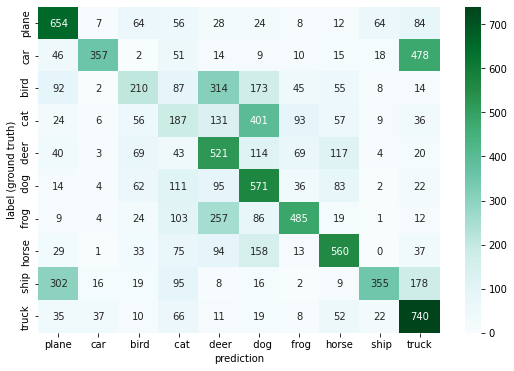

In [ ]:
net = train("Net_deeper", "RMSprop", eps=50)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.293
Epoch:2
	Batch:001 of 782, loss:1.800
Epoch:3
	Batch:001 of 782, loss:1.612
Epoch:4
	Batch:001 of 782, loss:1.698
Epoch:5
	Batch:001 of 782, loss:1.442
Epoch:6
	Batch:001 of 782, loss:1.422
Epoch:7
	Batch:001 of 782, loss:1.427
Epoch:8
	Batch:001 of 782, loss:1.447
Epoch:9
	Batch:001 of 782, loss:1.472
Epoch:10
	Batch:001 of 782, loss:1.390
Epoch:11
	Batch:001 of 782, loss:1.479
Epoch:12
	Batch:001 of 782, loss:1.435
Epoch:13
	Batch:001 of 782, loss:1.358
Epoch:14
	Batch:001 of 782, loss:1.330
Epoch:15
	Batch:001 of 782, loss:1.465
Epoch:16
	Batch:001 of 782, loss:1.460
Epoch:17
	Batch:001 of 782, loss:1.028
Epoch:18
	Batch:001 of 782, loss:1.449
Epoch:19
	Batch:001 of 782, loss:1.311
Epoch:20
	Batch:001 of 782, loss:1.331
Epoch:21
	Batch:001 of 782, loss:1.557
Epoch:22
	Batch:001 of 782, loss:1.534
Epoch:23
	Batch:001 of 782, loss:1.686
Epoch:24
	Batch:001 of 782, loss:1.277
Epoch:25
	Batch:001 of 782, loss:1.442
Epoch:26
	Batch:001 of 782, loss:

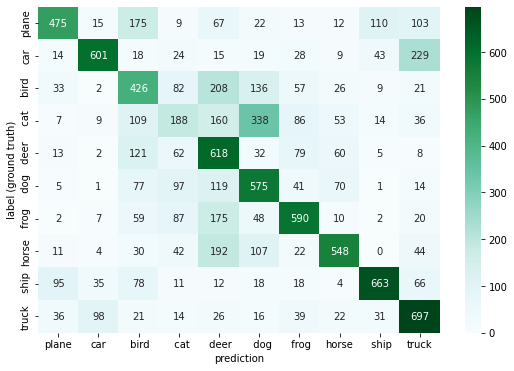

In [ ]:
net = train("Net", "RMSprop", eps=50)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.302
Epoch:2
	Batch:001 of 782, loss:1.627
Epoch:3
	Batch:001 of 782, loss:1.345
Epoch:4
	Batch:001 of 782, loss:1.224
Epoch:5
	Batch:001 of 782, loss:1.045
Epoch:6
	Batch:001 of 782, loss:1.130
Epoch:7
	Batch:001 of 782, loss:0.955
Epoch:8
	Batch:001 of 782, loss:0.824
Epoch:9
	Batch:001 of 782, loss:0.809
Epoch:10
	Batch:001 of 782, loss:0.915
Epoch:11
	Batch:001 of 782, loss:0.655
Epoch:12
	Batch:001 of 782, loss:0.708
Epoch:13
	Batch:001 of 782, loss:0.644
Epoch:14
	Batch:001 of 782, loss:0.562
Epoch:15
	Batch:001 of 782, loss:0.502
Epoch:16
	Batch:001 of 782, loss:0.657
Epoch:17
	Batch:001 of 782, loss:0.705
Epoch:18
	Batch:001 of 782, loss:0.525
Epoch:19
	Batch:001 of 782, loss:0.416
Epoch:20
	Batch:001 of 782, loss:0.514
Epoch:21
	Batch:001 of 782, loss:0.542
Epoch:22
	Batch:001 of 782, loss:0.400
Epoch:23
	Batch:001 of 782, loss:0.507
Epoch:24
	Batch:001 of 782, loss:0.561
Epoch:25
	Batch:001 of 782, loss:0.602
Epoch:26
	Batch:001 of 782, loss:

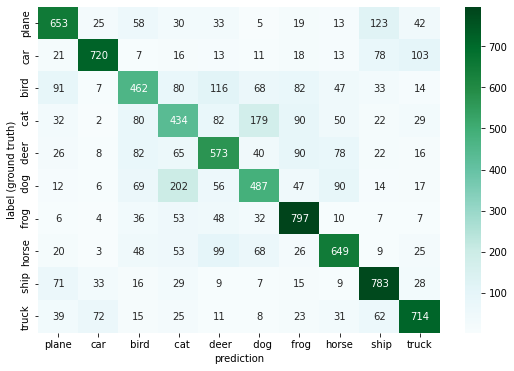

In [ ]:
net = train("Net", "SGD", lr=0.01,eps=30)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.315
Epoch:2
	Batch:001 of 782, loss:1.929
Epoch:3
	Batch:001 of 782, loss:1.357
Epoch:4
	Batch:001 of 782, loss:1.188
Epoch:5
	Batch:001 of 782, loss:1.250
Epoch:6
	Batch:001 of 782, loss:1.059
Epoch:7
	Batch:001 of 782, loss:0.985
Epoch:8
	Batch:001 of 782, loss:1.031
Epoch:9
	Batch:001 of 782, loss:0.782
Epoch:10
	Batch:001 of 782, loss:1.012
Epoch:11
	Batch:001 of 782, loss:0.786
Epoch:12
	Batch:001 of 782, loss:0.708
Epoch:13
	Batch:001 of 782, loss:0.782
Epoch:14
	Batch:001 of 782, loss:0.515
Epoch:15
	Batch:001 of 782, loss:0.855
Epoch:16
	Batch:001 of 782, loss:0.515
Epoch:17
	Batch:001 of 782, loss:0.470
Epoch:18
	Batch:001 of 782, loss:0.374
Epoch:19
	Batch:001 of 782, loss:0.615
Epoch:20
	Batch:001 of 782, loss:0.355
Epoch:21
	Batch:001 of 782, loss:0.383
Epoch:22
	Batch:001 of 782, loss:0.383
Epoch:23
	Batch:001 of 782, loss:0.399
Epoch:24
	Batch:001 of 782, loss:0.273
Epoch:25
	Batch:001 of 782, loss:0.370
Epoch:26
	Batch:001 of 782, loss:

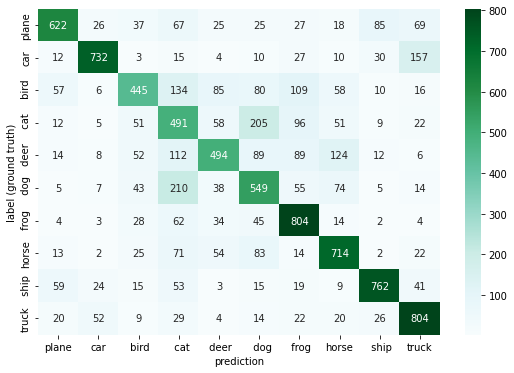

In [ ]:
net = train("Net_deeper", "SGD", lr=0.01,eps=30)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.312
Epoch:2
	Batch:001 of 782, loss:1.434
Epoch:3
	Batch:001 of 782, loss:1.062
Epoch:4
	Batch:001 of 782, loss:0.963
Epoch:5
	Batch:001 of 782, loss:0.867
Epoch:6
	Batch:001 of 782, loss:0.773
Epoch:7
	Batch:001 of 782, loss:0.717
Epoch:8
	Batch:001 of 782, loss:0.628
Epoch:9
	Batch:001 of 782, loss:0.628
Epoch:10
	Batch:001 of 782, loss:0.517
Epoch:11
	Batch:001 of 782, loss:0.540
Epoch:12
	Batch:001 of 782, loss:0.406
Epoch:13
	Batch:001 of 782, loss:0.296
Epoch:14
	Batch:001 of 782, loss:0.245
Epoch:15
	Batch:001 of 782, loss:0.350
Epoch:16
	Batch:001 of 782, loss:0.322
Epoch:17
	Batch:001 of 782, loss:0.413
Epoch:18
	Batch:001 of 782, loss:0.206
Epoch:19
	Batch:001 of 782, loss:0.135
Epoch:20
	Batch:001 of 782, loss:0.223
Epoch:21
	Batch:001 of 782, loss:0.150
Epoch:22
	Batch:001 of 782, loss:0.199
Epoch:23
	Batch:001 of 782, loss:0.384
Epoch:24
	Batch:001 of 782, loss:0.241
Epoch:25
	Batch:001 of 782, loss:0.212
Epoch:26
	Batch:001 of 782, loss:

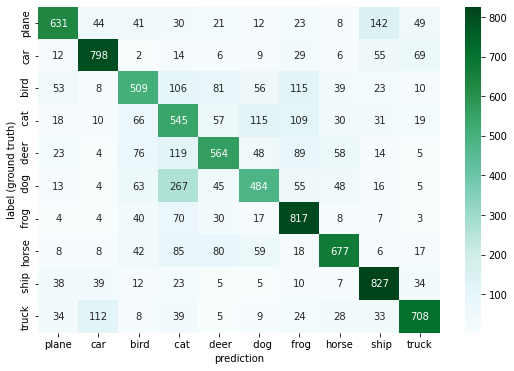

In [ ]:
net = train("Net_wider", "SGD", lr=0.01,eps=30)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.303
Epoch:2
	Batch:001 of 782, loss:2.301
Epoch:3
	Batch:001 of 782, loss:2.302
Epoch:4
	Batch:001 of 782, loss:2.300
Epoch:5
	Batch:001 of 782, loss:2.298
Epoch:6
	Batch:001 of 782, loss:2.294
Epoch:7
	Batch:001 of 782, loss:2.232
Epoch:8
	Batch:001 of 782, loss:2.194
Epoch:9
	Batch:001 of 782, loss:1.935
Epoch:10
	Batch:001 of 782, loss:1.587
Epoch:11
	Batch:001 of 782, loss:1.703
Epoch:12
	Batch:001 of 782, loss:1.715
Epoch:13
	Batch:001 of 782, loss:1.360
Epoch:14
	Batch:001 of 782, loss:1.423
Epoch:15
	Batch:001 of 782, loss:1.458
Epoch:16
	Batch:001 of 782, loss:1.491
Epoch:17
	Batch:001 of 782, loss:1.276
Epoch:18
	Batch:001 of 782, loss:1.232
Epoch:19
	Batch:001 of 782, loss:1.272
Epoch:20
	Batch:001 of 782, loss:1.046
Epoch:21
	Batch:001 of 782, loss:0.711
Epoch:22
	Batch:001 of 782, loss:1.042
Epoch:23
	Batch:001 of 782, loss:1.104
Epoch:24
	Batch:001 of 782, loss:1.006
Epoch:25
	Batch:001 of 782, loss:1.044
Epoch:26
	Batch:001 of 782, loss:

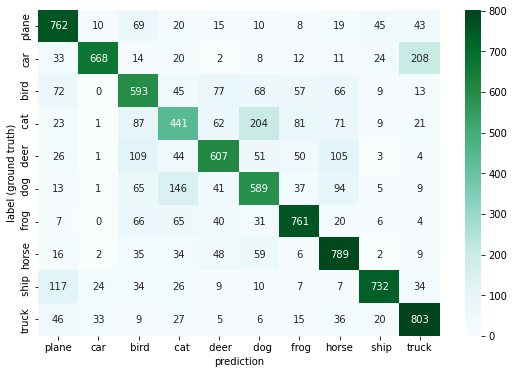

In [ ]:
class Net_custom(nn.Module):
    def __init__(self):
        super(Net_custom, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, 1, 1)
        self.conv2 = nn.Conv2d(6, 16, 3, 1, 1)
        self.conv3 = nn.Conv2d(16, 32, 3, 1, 1)
        self.conv4 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(64 * 2 * 2, 240)
        self.fc2 = nn.Linear(240, 120)
        self.fc3 = nn.Linear(120, 10)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 64 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net_custom().to(device)

optimizer = get_optimizer("SGD", net.parameters())
criterion = nn.CrossEntropyLoss()

for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0  #?????????
    for i, data in enumerate(trainloader, 0):
            # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

            # zero the parameter gradients
        optimizer.zero_grad()

            # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

            # print statistics
        if i == 0:
            print(f"\nEpoch:{epoch+1}")
            print(f"\r\tBatch:{i+1:03} of {len(trainloader)}, loss:{loss.item():.3f}", end='')

print('\nFinished Training')

test(net)


Epoch:1
	Batch:001 of 782, loss:2.318
Epoch:2
	Batch:001 of 782, loss:2.313
Epoch:3
	Batch:001 of 782, loss:2.306
Epoch:4
	Batch:001 of 782, loss:2.301
Epoch:5
	Batch:001 of 782, loss:2.302
Epoch:6
	Batch:001 of 782, loss:2.307
Epoch:7
	Batch:001 of 782, loss:2.289
Epoch:8
	Batch:001 of 782, loss:2.296
Epoch:9
	Batch:001 of 782, loss:2.304
Epoch:10
	Batch:001 of 782, loss:2.292
Epoch:11
	Batch:001 of 782, loss:2.288
Epoch:12
	Batch:001 of 782, loss:2.284
Epoch:13
	Batch:001 of 782, loss:2.243
Epoch:14
	Batch:001 of 782, loss:2.226
Epoch:15
	Batch:001 of 782, loss:2.199
Epoch:16
	Batch:001 of 782, loss:2.107
Epoch:17
	Batch:001 of 782, loss:1.971
Epoch:18
	Batch:001 of 782, loss:1.983
Epoch:19
	Batch:001 of 782, loss:2.132
Epoch:20
	Batch:001 of 782, loss:1.984
Epoch:21
	Batch:001 of 782, loss:1.898
Epoch:22
	Batch:001 of 782, loss:1.880
Epoch:23
	Batch:001 of 782, loss:2.067
Epoch:24
	Batch:001 of 782, loss:1.856
Epoch:25
	Batch:001 of 782, loss:1.977
Epoch:26
	Batch:001 of 782, loss:

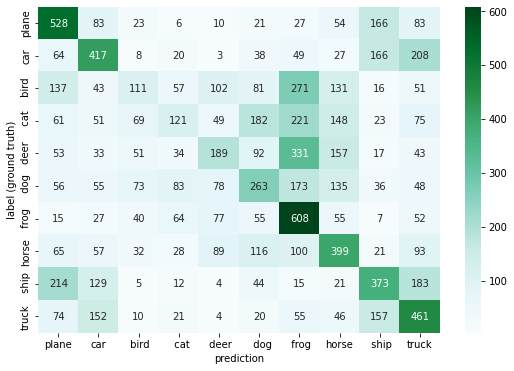

In [ ]:
net = train("Net", "SGD", lr=0.0001,eps=30)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.320
Epoch:2
	Batch:001 of 782, loss:2.308
Epoch:3
	Batch:001 of 782, loss:2.300
Epoch:4
	Batch:001 of 782, loss:2.302
Epoch:5
	Batch:001 of 782, loss:2.305
Epoch:6
	Batch:001 of 782, loss:2.298
Epoch:7
	Batch:001 of 782, loss:2.302
Epoch:8
	Batch:001 of 782, loss:2.309
Epoch:9
	Batch:001 of 782, loss:2.304
Epoch:10
	Batch:001 of 782, loss:2.298
Epoch:11
	Batch:001 of 782, loss:2.304
Epoch:12
	Batch:001 of 782, loss:2.306
Epoch:13
	Batch:001 of 782, loss:2.302
Epoch:14
	Batch:001 of 782, loss:2.302
Epoch:15
	Batch:001 of 782, loss:2.302
Epoch:16
	Batch:001 of 782, loss:2.305
Epoch:17
	Batch:001 of 782, loss:2.302
Epoch:18
	Batch:001 of 782, loss:2.300
Epoch:19
	Batch:001 of 782, loss:2.303
Epoch:20
	Batch:001 of 782, loss:2.301
Epoch:21
	Batch:001 of 782, loss:2.300
Epoch:22
	Batch:001 of 782, loss:2.301
Epoch:23
	Batch:001 of 782, loss:2.302
Epoch:24
	Batch:001 of 782, loss:2.302
Epoch:25
	Batch:001 of 782, loss:2.301
Epoch:26
	Batch:001 of 782, loss:

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


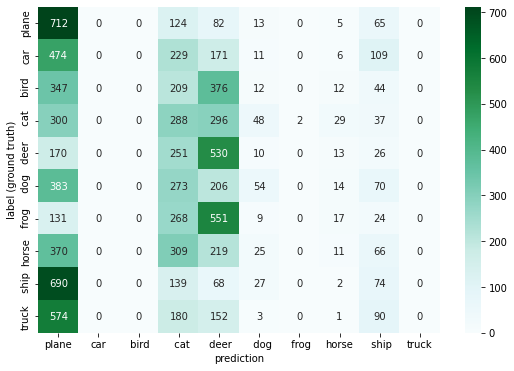

In [ ]:
net = train("Net_deeper", "SGD", lr=0.0001,eps=30)
test(net)


Epoch:1
	Batch:001 of 782, loss:2.305
Epoch:2
	Batch:001 of 782, loss:2.298
Epoch:3
	Batch:001 of 782, loss:2.302
Epoch:4
	Batch:001 of 782, loss:2.292
Epoch:5
	Batch:001 of 782, loss:2.291
Epoch:6
	Batch:001 of 782, loss:2.295
Epoch:7
	Batch:001 of 782, loss:2.290
Epoch:8
	Batch:001 of 782, loss:2.299
Epoch:9
	Batch:001 of 782, loss:2.269
Epoch:10
	Batch:001 of 782, loss:2.258
Epoch:11
	Batch:001 of 782, loss:2.215
Epoch:12
	Batch:001 of 782, loss:2.183
Epoch:13
	Batch:001 of 782, loss:2.162
Epoch:14
	Batch:001 of 782, loss:2.103
Epoch:15
	Batch:001 of 782, loss:2.068
Epoch:16
	Batch:001 of 782, loss:1.855
Epoch:17
	Batch:001 of 782, loss:2.046
Epoch:18
	Batch:001 of 782, loss:1.838
Epoch:19
	Batch:001 of 782, loss:1.843
Epoch:20
	Batch:001 of 782, loss:1.949
Epoch:21
	Batch:001 of 782, loss:1.876
Epoch:22
	Batch:001 of 782, loss:1.931
Epoch:23
	Batch:001 of 782, loss:1.879
Epoch:24
	Batch:001 of 782, loss:1.703
Epoch:25
	Batch:001 of 782, loss:1.926
Epoch:26
	Batch:001 of 782, loss:

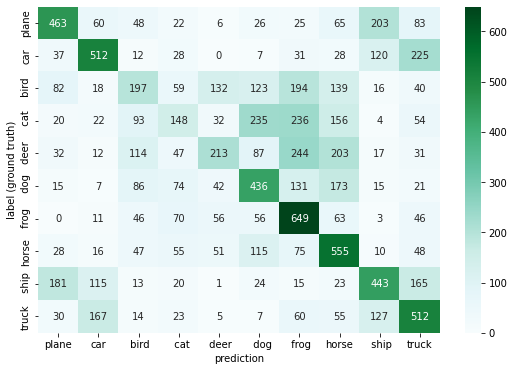

In [ ]:
net = train("Net_wider", "SGD", lr=0.0001,eps=30)
test(net)